In [282]:
import os
import pandas as pd

data_folder = "/home/nayanika/myelin-h/neuroengineering/EMG-data-task2/EMG/EMG"

# Only analyse 1 subject at a time 

def read_and_structure_data(data_folder):
    data = []

    # Iterate through each CSV file
    for root, dirs, files in os.walk(data_folder):
        files = sorted(files)
        print(files)
        for file in files:
            if file.endswith(".csv"):
                # print(file)

                if file == "U3Ex2Rep3.csv" or file == "U1Ex1Rep3.csv":
                    pass
                    print(f'file missing: {file}')

                else:
                    file_path = os.path.join(root, file)

                    # Extract information from the file name
                    user_id = file.split('E')[0]
                    exercise_id = file.split('R')[0][-1]
                    repetition_id = int(file.split('.')[0][-1])

                    # Read CSV file into a DataFrame
                    df = pd.read_csv(file_path)
                    df.columns = ['Time', 'EMG Raw data', 'label']

                    # print(df.head)

                    if user_id == "U1":
                        print(user_id)
                        # Append data to the list
                        data.append({
                            'user_id': user_id,
                            'exercise_id': exercise_id,
                            'repetition_id': repetition_id,
                            'time': df['Time'],
                            'emg_raw_data': df['EMG Raw data'],
                            'label': df['label'] # Assuming label is constant for the entire file
                        })

                    # print(f'aa:{data}')

    # Convert the list of dictionaries to a DataFrame
    structured_data = pd.DataFrame(data)

    # print(data)

    return structured_data

# Example usage
structured_data = read_and_structure_data(data_folder)

# Print the structured data
print(structured_data.head)


['U10Ex1Rep1.csv', 'U10Ex1Rep2.csv', 'U10Ex1Rep3.csv', 'U10Ex2Rep1.csv', 'U10Ex2Rep2.csv', 'U10Ex2Rep3.csv', 'U10Ex3Rep1.csv', 'U10Ex3Rep2.csv', 'U10Ex3Rep3.csv', 'U1Ex1Rep1.csv', 'U1Ex1Rep2.csv', 'U1Ex1Rep3.csv', 'U1Ex2Rep1.csv', 'U1Ex2Rep2.csv', 'U1Ex2Rep3.csv', 'U1Ex3Rep1.csv', 'U1Ex3Rep2.csv', 'U1Ex3Rep3.csv', 'U2Ex1Rep1.csv', 'U2Ex1Rep2.csv', 'U2Ex1Rep3.csv', 'U2Ex2Rep1.csv', 'U2Ex2Rep2.csv', 'U2Ex2Rep3.csv', 'U2Ex3Rep1.csv', 'U2Ex3Rep2.csv', 'U2Ex3Rep3.csv', 'U3Ex1Rep1.csv', 'U3Ex1Rep2.csv', 'U3Ex1Rep3.csv', 'U3Ex2Rep1.csv', 'U3Ex2Rep2.csv', 'U3Ex2Rep3.csv', 'U3Ex3Rep1.csv', 'U3Ex3Rep2.csv', 'U3Ex3Rep3.csv', 'U4Ex1Rep1.csv', 'U4Ex1Rep2.csv', 'U4Ex1Rep3.csv', 'U4Ex2Rep1.csv', 'U4Ex2Rep2.csv', 'U4Ex2Rep3.csv', 'U4Ex3Rep1.csv', 'U4Ex3Rep2.csv', 'U4Ex3Rep3.csv', 'U5Ex1Rep1.csv', 'U5Ex1Rep2.csv', 'U5Ex1Rep3.csv', 'U5Ex2Rep1.csv', 'U5Ex2Rep2.csv', 'U5Ex2Rep3.csv', 'U5Ex3Rep1.csv', 'U5Ex3Rep2.csv', 'U5Ex3Rep3.csv', 'U6Ex1Rep1.csv', 'U6Ex1Rep2.csv', 'U6Ex1Rep3.csv', 'U6Ex2Rep1.csv', 'U6E

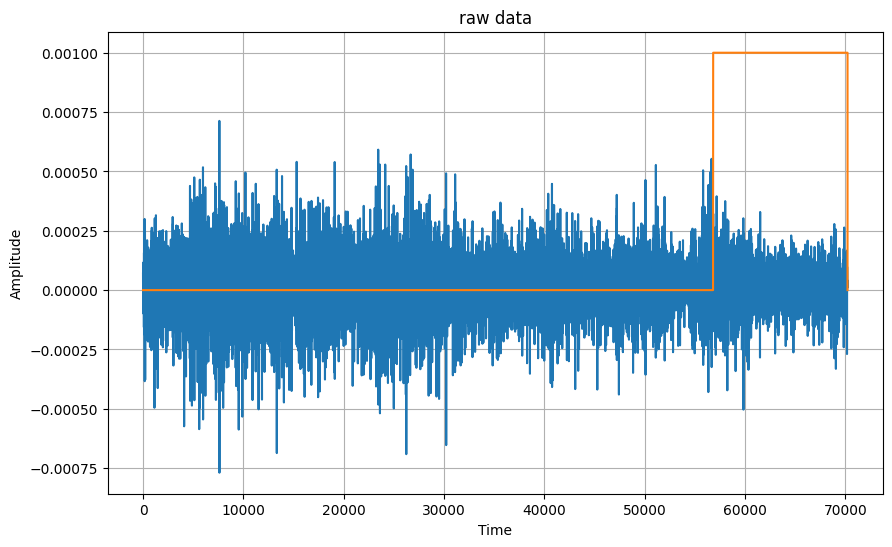

999.9715140293404


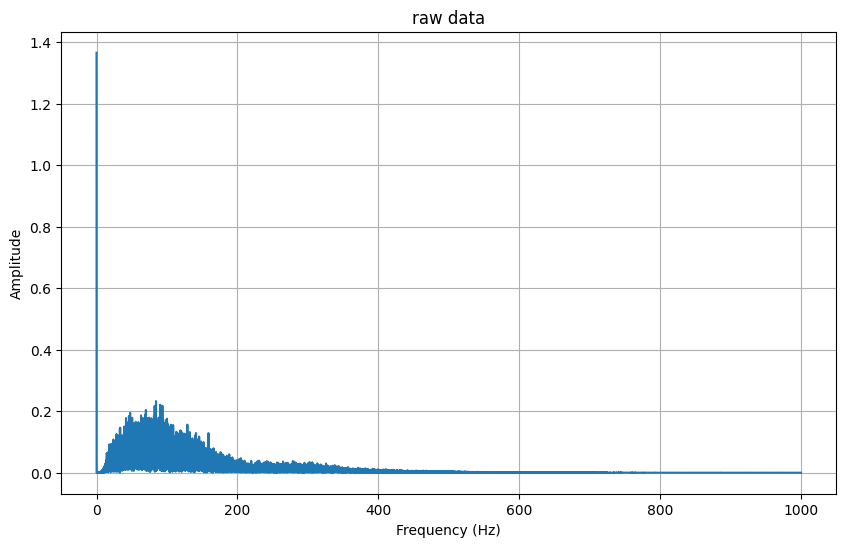

In [283]:
import matplotlib.pyplot as plt
import numpy as np

i=0

signal = structured_data['emg_raw_data'].iloc[i]
time = structured_data['time'].iloc[i]
label = structured_data['label'].iloc[i]

fs = 2000

plt.figure(figsize=(10, 6))
plt.plot(signal)
plt.plot(label*0.001)
plt.title('raw data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


# Compute FFT
fft_result = np.fft.fft(signal)
fft_frequencies = np.fft.fftfreq(len(signal), d=1/2000 )

print(max(fft_frequencies))


plt.figure(figsize=(10, 6))
plt.plot(fft_frequencies[0:len(signal)//2], np.abs(fft_result[0:len(signal)//2]))
plt.title('raw data')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [314]:
from scipy.signal import butter, filtfilt, convolve, welch

fs= 2000

def bandpass_filter(data, sampling_rate, lowcut, highcut, order=4):
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(N=order, Wn=[low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Function to compute RMS in a sliding window
def sliding_window_rms(signal, window_size):
    squared_signal = signal**2
    box = np.ones(window_size)/window_size
    rms = np.sqrt(convolve(squared_signal, box, mode='same'))
    return rms

def extract_windows_and_compute_psd(time_series, window_size=2000, overlap=1000):
    windows = []
    window_psd = []
    start = 0

    while start + window_size <= len(time_series):
        end = start + window_size
        window = time_series[start:end]
        windows.append(window)
        start += overlap
        frequencies, psd= welch(window, fs=fs, nperseg=128)
        window_psd.append(np.log10(psd))

    return windows, window_psd


data = []
features = []
labels = []
for i in range(len(structured_data)):

    filtered_data = bandpass_filter(structured_data['emg_raw_data'][i], fs, 30, 300)
    abs_data = np.abs(filtered_data)
    rms = sliding_window_rms(structured_data['emg_raw_data'][i], 25) # 50 ms window

    nf = filtered_data[structured_data['label'].iloc[i] == 0]
    f = filtered_data[structured_data['label'].iloc[i] == 1]
    
    # Compute FFT
    nf_fft = np.fft.fft(nf)[0:len(nf)//2]
    nf_fft_frequencies = np.fft.fftfreq(len(nf), d=1/2000 )[0:len(nf)//2]

    # Compute FFT
    f_fft = np.fft.fft(f)[0:len(f)//2]
    f_fft_frequencies = np.fft.fftfreq(len(f), d=1/2000 )[0:len(f)//2]

    nf_frequencies, nf_psd= welch(nf, fs=fs, nperseg=256)
    f_frequencies, f_psd= welch(f, fs=fs, nperseg=256)

    # Extract windows with 1000-sample overlap
    nf_trials, nf_trials_psd = extract_windows_and_compute_psd(nf, window_size=2000, overlap=1000)
    f_trials, f_trials_psd = extract_windows_and_compute_psd(f, window_size=2000, overlap=1000)


    data.append({'filtered_data': filtered_data,
                 'abs_data': abs_data,
                 'rms': rms,
                 'nf': nf,
                 'f': f,
                 'nf_fft': [nf_fft, nf_fft_frequencies],
                 'f_fft': [f_fft, f_fft_frequencies],
                'nf_psd': [np.log10(nf_psd), nf_frequencies],
                'f_psd': [np.log10(f_psd), f_frequencies]})
    
    # features.append(np.log10(nf_psd)) 
    # features.append(np.log10(f_psd))
    # labels.append(0)
    # labels.append(1)

    features.append(nf_trials_psd)
    features.append(f_trials_psd)
    labels.append([0]*(len(nf_trials_psd)))
    labels.append([1]*(len(f_trials_psd)))


assert(len(features) == len(labels))

from itertools import chain

features = list(chain.from_iterable(features))
labels = list(chain.from_iterable(labels))

assert(len(features) == len(labels))

print(len(features))
print(labels)


374
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [34]:
# steps
1. bandpass filter
2. absolute value of signal
3. sliding window rms
4. fft
5. psd (works for data of varying length)

SyntaxError: invalid syntax (4112970412.py, line 2)

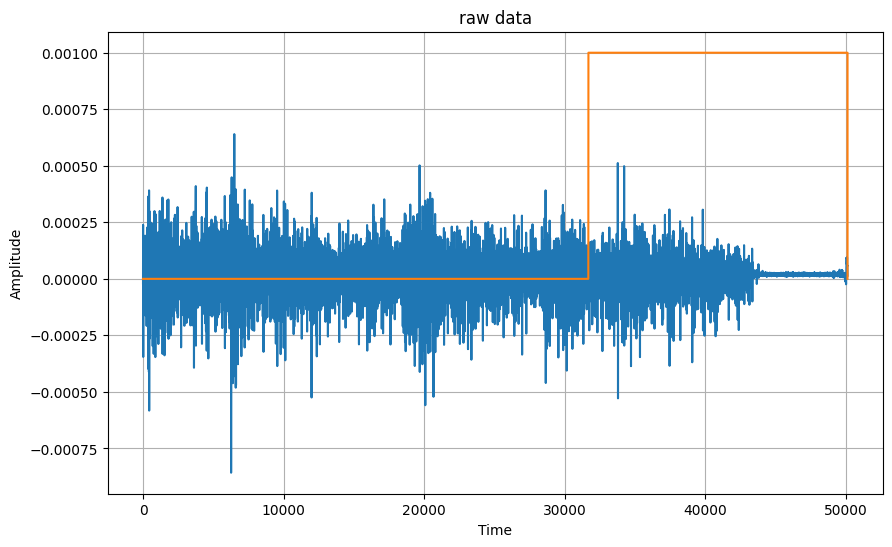

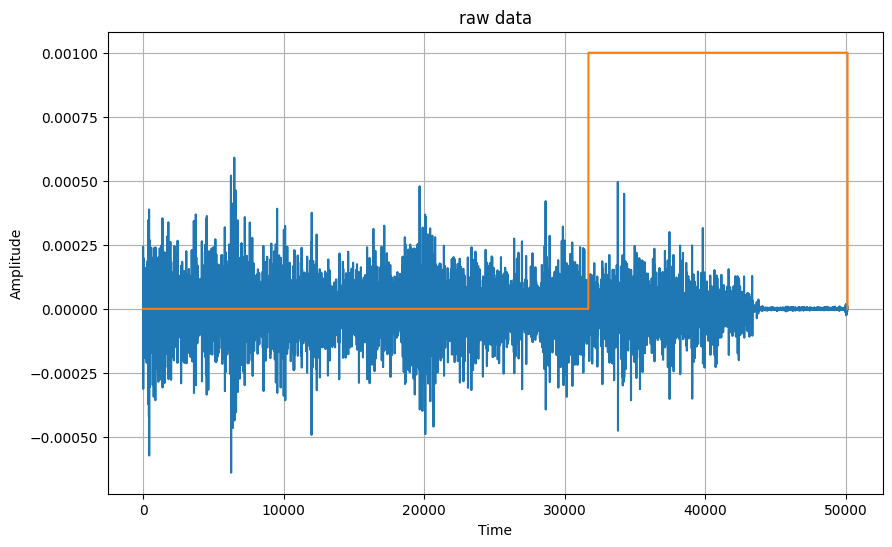

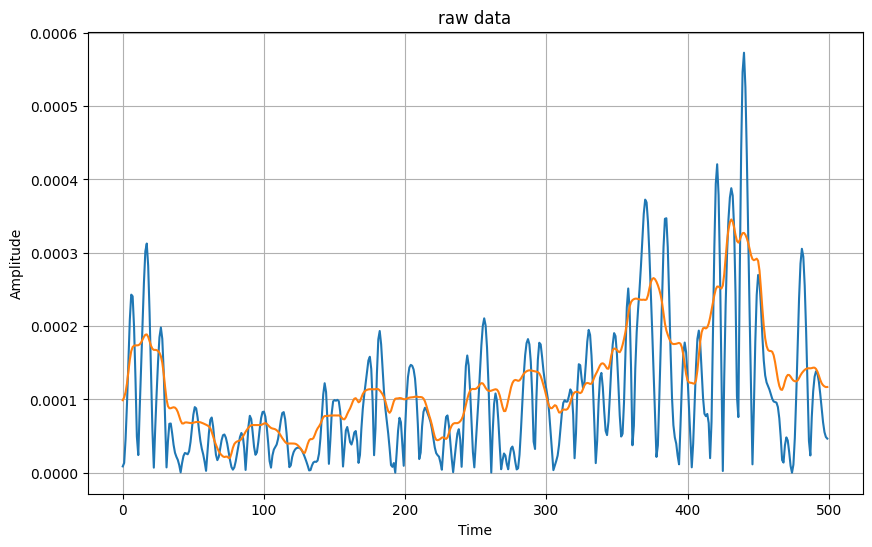

/home/nayanika/anaconda3/envs/myelin-h/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


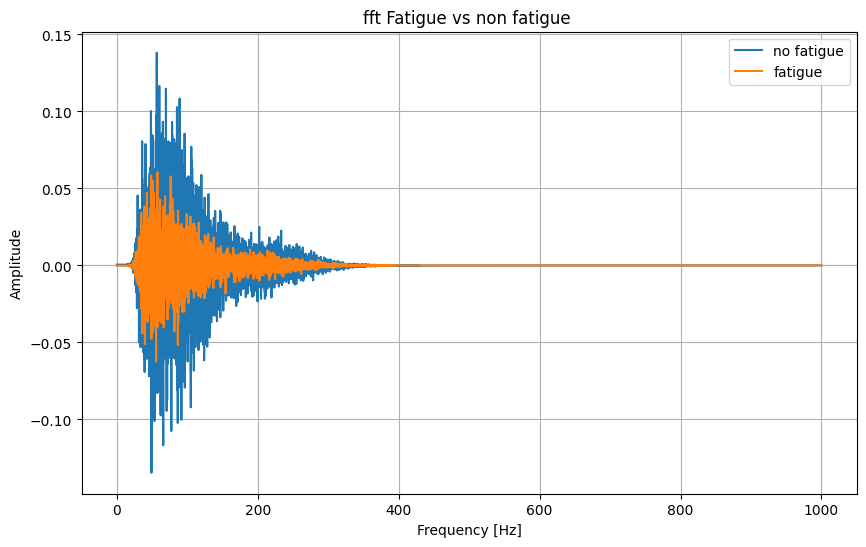

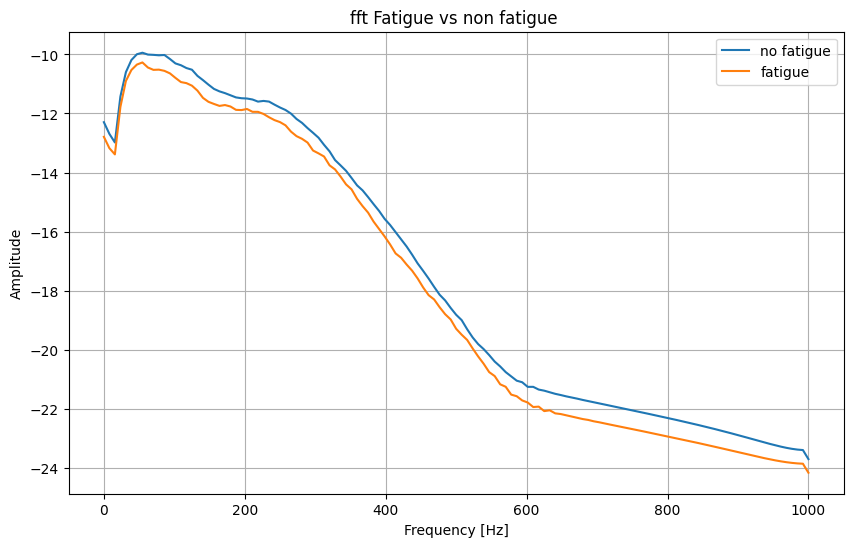

In [315]:
i=3

raw = structured_data['emg_raw_data'].iloc[i]
filtered = data[i]['filtered_data']
abs = data[i]['abs_data']
rms = data[i]['rms']
label = structured_data['label'].iloc[i]
nf_fft = data[i]['nf_fft']
f_fft = data[i]['f_fft']
nf_psd = data[i]['nf_psd']
f_psd = data[i]['f_psd']

assert(len(nf_psd[1])==len(f_psd[1]))

plt.figure(figsize=(10, 6))
plt.plot(raw)
plt.plot(label*0.001)
plt.title('raw data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(filtered)
plt.plot(label*0.001)
plt.title('raw data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(abs[0:500])
plt.plot(rms[0:500])
# plt.plot(label*0.001)
plt.title('raw data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(nf_fft[1], nf_fft[0], label ='no fatigue')
# plt.plot(label*0.001)
plt.plot(f_fft[1], f_fft[0], label ='fatigue')
plt.title('fft Fatigue vs non fatigue ')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(nf_psd[1], nf_psd[0], label ='no fatigue')
# plt.plot(label*0.001)
plt.plot(f_psd[1], f_psd[0], label ='fatigue')
plt.title('fft Fatigue vs non fatigue ')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()



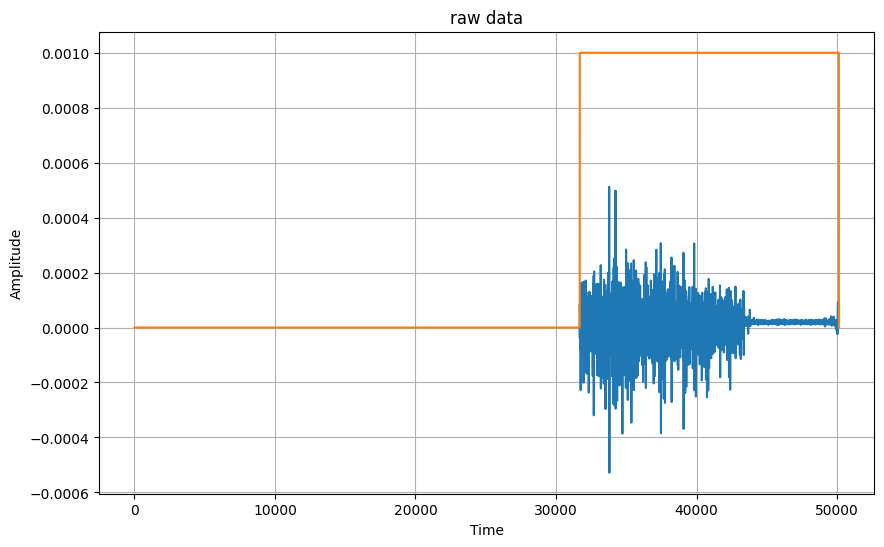

In [286]:
# Separate the time series based on the label variable

df = structured_data

nf = df['emg_raw_data'].iloc[i][df['label'].iloc[i] == 0]
f = df['emg_raw_data'].iloc[i][df['label'].iloc[i] == 1]


plt.figure(figsize=(10, 6))
plt.plot(f)
plt.plot(label*0.001)
plt.title('raw data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


374
374
[7.66450775e-01 1.63051517e-01 2.55880413e-02 1.30879245e-02
 7.76313223e-03 4.99363677e-03 2.62536100e-03 2.38314643e-03
 1.46408538e-03 1.38858557e-03 1.20166919e-03 1.02685034e-03
 9.59017755e-04 8.53622562e-04 6.55429404e-04 5.83708999e-04
 5.06776951e-04 4.95580692e-04 4.63209640e-04 4.47293810e-04
 4.08118363e-04 3.58223064e-04 3.33519880e-04 2.89138444e-04
 2.60792111e-04 2.41242147e-04 2.20628565e-04 2.17277416e-04
 2.02035007e-04 1.75708766e-04 1.63173073e-04 1.46930707e-04
 1.38664381e-04 1.32969287e-04 1.17600340e-04 1.08687591e-04
 8.53523899e-05 7.89691987e-05 7.34949592e-05 6.63630701e-05
 5.93622661e-05 5.74786333e-05 3.65858848e-05 1.78918788e-05
 1.16505025e-05 5.40732485e-06 2.37029745e-06 5.45754770e-07
 2.86867078e-07 1.11847462e-07 2.77087833e-08 1.35134348e-08
 9.13928409e-09 3.37669472e-09 1.53313569e-09 1.67208457e-10
 7.95448507e-11 2.64558799e-11 8.16553782e-12 1.56745355e-12
 3.97784637e-13 8.82254580e-14 1.56469166e-14 1.83719622e-15
 8.89489072e-17]

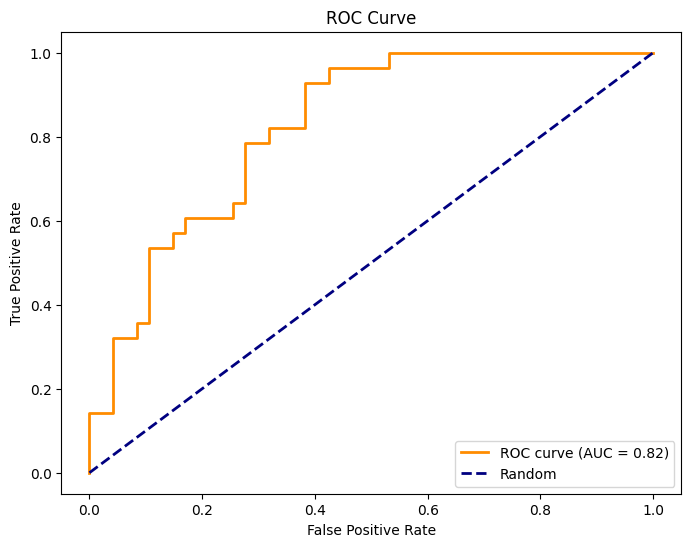

In [316]:
print(len(features))
print(len(labels))

# print(features[0].shape)
# print(labels)
# features_df = pd.DataFrame(features)

# print(features_df.shape)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.linear_model import LogisticRegression as lr
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc 
from sklearn.model_selection import train_test_split

# Step 1: Apply PCA
pca = PCA(n_components=features[1].shape[0])
features_pca = pca.fit_transform(features)
print(pca.explained_variance_ratio_)
print(features_pca.shape)
# components = np.sum(pca.explained_variance_ratio_>0.004)
# print(components)

X_train, X_test, Y_train, Y_test = train_test_split(features_pca[:,0:10], labels, test_size=0.2, random_state=4)

# print(Y_train)

# # Create and train LDA classifier
# lda_model = lda()
# lda_model.fit(X_train, Y_train)

# # Make predictions on the test set
# Y_pred = lda_model.predict(X_test)
# Y_probs = lda_model.predict_proba(X_test)[:, 1]

# Create and train LDA classifier
lr_model = lr()
lr_model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = lr_model.predict(X_test)
Y_probs = lr_model.predict_proba(X_test)[:, 1]

# Evaluate the performance
conf_mat = confusion_matrix(Y_test, Y_pred)
accuracy = accuracy_score(Y_test, Y_pred)
fpr, tpr, thresholds = roc_curve(Y_test, Y_probs)

# Compute Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

print("Confusion Matrix:")
print(conf_mat)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


